In [1]:
import numpy as np
import pandas as pd

import re

import sys
sys.path.append('../')
from lib.Dab import Dab, get_linear_weights
from lib.Gmt import read_gmt

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%%time
d = Dab('../data/global.dab')

CPU times: user 5.1 s, sys: 2.6 s, total: 7.7 s
Wall time: 7.7 s


In [3]:
from lib.clustering import *

In [4]:
def read_csv(file_name):
    return pd.DataFrame.from_csv(file_name, sep='\t', index_col=None)

# Modularity

Calculate the fraction of total network weight taken up by the low weights in the network

In [5]:
d_weights = get_linear_weights(d)

In [6]:
res = []
total = d_weights.sum()
for i in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    frac = d_weights[d_weights <= i].sum()/total
    res.append({
        'cutoff_weight': i,
        'fraction': frac
    })
pd.DataFrame(res)

cutoff_weight  fraction
0          0.001  0.004652
1          0.005  0.133060
2          0.010  0.608432
3          0.050  0.940956
4          0.100  0.961066
5          0.200  0.975877
6          0.300  0.983167
7          0.400  0.987830
8          0.500  0.991284

In [7]:
res = []
total = d_weights.sum()
percentiles = [80, 90, 95, 99]
percentile_cutoffs = np.percentile(d_weights, percentiles)
for percentile, cutoff in zip(percentiles, percentile_cutoffs):
    frac = d_weights[d_weights >= cutoff].sum()/total
    res.append({
        'cutoff_percentile': percentile,
        'cutoff_value': cutoff,
        'fraction': frac
    })
pd.DataFrame(res)

cutoff_percentile  cutoff_value  fraction
0                 80      0.010000  0.391550
1                 90      0.010086  0.240708
2                 95      0.010779  0.169211
3                 99      0.024732  0.089876

Calculate the average modularity scores for each algorithm

In [8]:
f = read_csv('../preprocessing_tests/modularity_cutoff_gobp.tsv')
f = f.append(read_csv('../preprocessing_tests/modularity_cutoff_gocc.tsv'))
f.columns

Index([u'test_case', u'test_number', u'transform', u'gene_sets', u'n_genes',
       u'modularity'],
      dtype='object')

In [9]:
f['cutoff'] = [float(re.search('Cutoff\((.+)\)', t).group(1)) for t in f['transform']]
f['transform'] = [t.split('>')[0].strip() for t in f['transform']]

In [10]:
f['test_size'] = [int(t.split(' ')[2]) for t in f['test_case']]
f['test_type'] = [t.split(' ')[1] for t in f['test_case']]
f['test_terms'] = [t.split(' ')[3] for t in f['test_case']]

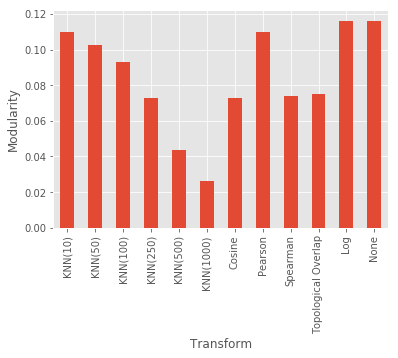

modularity
transform                      
KNN(10)                0.109702
KNN(50)                0.102331
KNN(100)               0.093154
KNN(250)               0.073053
KNN(500)               0.043892
KNN(1000)              0.026422
Cosine                 0.072987
Pearson                0.109956
Spearman               0.074172
Topological Overlap    0.075065
Log                    0.116273
None                   0.116272

In [11]:
order = ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
x = f.groupby(['transform']).agg({'modularity':np.mean}).transpose()[order].transpose()
x.plot(kind='bar', legend=False)
plt.gca().legend().remove()
plt.ylabel('Modularity')
plt.xlabel('Transform')
plt.show()
x

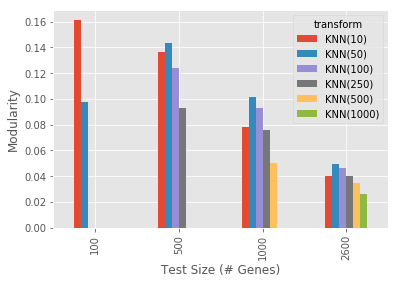

In [12]:
knn_transforms = ['KNN(%d)' % s for s in 10,50,100,250,500,1000]
x = f[f.transform.isin(knn_transforms)].groupby(['test_size', 'transform'], as_index=False).agg(np.mean)
#x
pd.pivot_table(x, values='modularity', columns='transform', index='test_size')[knn_transforms].plot.bar()

plt.ylabel('Modularity')
plt.xlabel('Test Size (# Genes)')
plt.show()

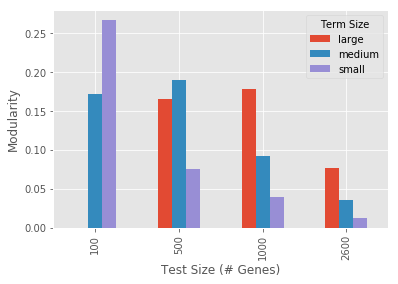

In [13]:

x = f[f.transform.isin(['None'])].groupby(['test_size', 'test_terms'], as_index=False).agg(np.mean)
x = pd.pivot_table(x, values='modularity', columns='test_terms', index='test_size')
#x['all'] = f[f.transform.isin(['None'])].groupby(['test_size']).agg(np.mean)['modularity']
#print x['all']
x.plot.bar()
plt.ylabel('Modularity')
plt.xlabel('Test Size (# Genes)')
plt.legend().set_title('Term Size')
plt.show()

In [14]:
def count_times_outperformed(f):
    g = f.groupby(['test_case', 'test_number'])
    wins = {t: 0 for t in f.transform.unique() if t != 'None'}
    cases = 0.0
    for index, group in g:
        cases += 1
        none_value = group[group.transform == 'None'].modularity.values[0]
        for r in group.itertuples():
            if r.modularity > none_value and r.transform != 'None':
                wins[r.transform] += 1
    x = pd.DataFrame(wins.items(), columns=['transform', 'wins'])
    x['percent'] = x['wins'] / cases
    return x

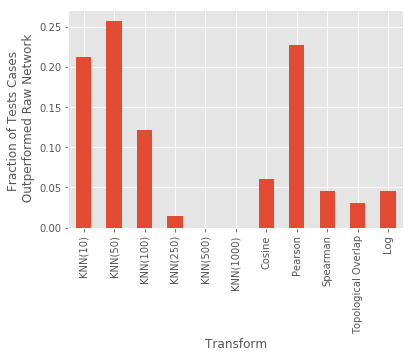

In [15]:
order = ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log']
x = count_times_outperformed(f)
x.set_index('transform').ix[order].plot.bar(y='percent')
plt.gca().legend().remove()
plt.xlabel("Transform")
plt.ylabel("Fraction of Tests Cases \n Outperformed Raw Network")
plt.show()

In [16]:
f.groupby(['test_type']).agg(np.mean)

test_number  gene_sets      n_genes  modularity  cutoff  \
test_type                                                            
BP                 2.0  39.666667  1202.623306    0.076892     5.0   
CC                 2.0  19.003367   867.050505    0.109443     5.0   

             test_size  
test_type               
BP         1170.731707  
CC          824.242424

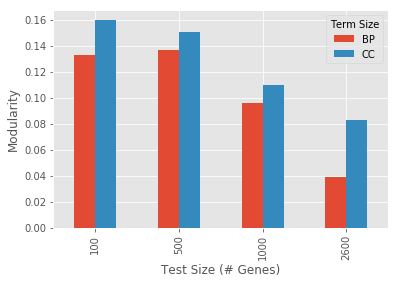

In [17]:
x = f[f.transform.isin(['None'])].groupby(['test_size', 'test_type'], as_index=False).agg(np.mean)
x = pd.pivot_table(x, values='modularity', columns='test_type', index='test_size')
#x['all'] = f[f.transform.isin(['None'])].groupby(['test_size']).agg(np.mean)['modularity']
#print x['all']
x.plot.bar()
plt.ylabel('Modularity')
plt.xlabel('Test Size (# Genes)')
plt.legend().set_title('Term Size')
plt.show()

# Internal Connectivity

In [19]:
def get_fraction_significant(connectivity_results):
    grouped = connectivity_results.groupby(['test_case', 'test_number', 'transform'])
    aggregates = []
    for labels, f in grouped:
        n = len(f)
        pval_cutoff = 0.05/n
        number_significant = len(f[f.calculated_pval < pval_cutoff])
        number_experimental_significant = len(f[f.experimental_pval < 0.01])
        fraction_significant = number_significant / float(n)
        fraction_experimental_significant = number_experimental_significant / float(n)
        aggregates.append(labels + (n, number_significant, number_experimental_significant, 
                                    fraction_significant, fraction_experimental_significant))
    connectivity_summary = pd.DataFrame(aggregates, 
            columns=['test_case', 'test_number', 'transform','total_number', 'number_significant', 
                     'number_experimental_significant', 'fraction_significant', 
                     'fraction_experimental_significant'])
    return connectivity_summary


In [45]:
def count_times_outperformed(f, metric):
    g = f.groupby(['test_case', 'test_number'])
    wins = {t: 0 for t in f.transform.unique() if t != 'None'}
    cases = 0.0
    for index, group in g:
        cases += 1
        none_value = group[group.transform == 'None'][metric].values[0]
        for r in group.itertuples():
            if getattr(r, metric) > none_value and r.transform != 'None':
                wins[r.transform] += 1
    x = pd.DataFrame(wins.items(), columns=['transform', 'wins'])
    x['percent'] = x['wins'] / cases
    return x

In [71]:
def count_ratio_outperformed(f, metric):
    g = f.groupby(['test_case', 'test_number'])
    performance = []
    for index, group in g:
        none_value = group[group.transform == 'None'][metric].values[0]
        if none_value == 0:
            continue
        for r in group.itertuples():
            performance.append((r.transform, float(getattr(r, metric))/none_value))
            if r.transform == 'None':
                if none_value != getattr(r, metric):
                    print index, none_value, getattr(r, metric)
                assert none_value == getattr(r, metric)
    x = pd.DataFrame(performance, columns=['transform', 'percent_enrich'])
    return x.groupby(['transform'], as_index=False).mean()

In [263]:
x = read_csv('../preprocessing_tests/connectivity_gobp.tsv')
x = x.append(read_csv('../preprocessing_tests/connectivity_gocc.tsv'))

In [264]:
f = get_fraction_significant(x)

In [265]:
f['test_size'] = [int(t.split(' ')[2]) for t in f['test_case']]
f['test_type'] = [t.split(' ')[1] for t in f['test_case']]
f['test_terms'] = [t.split(' ')[3] for t in f['test_case']]

Get the average number of times outperforming the untransformed network

In [266]:
wins = count_times_outperformed(f, 'number_experimental_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log']

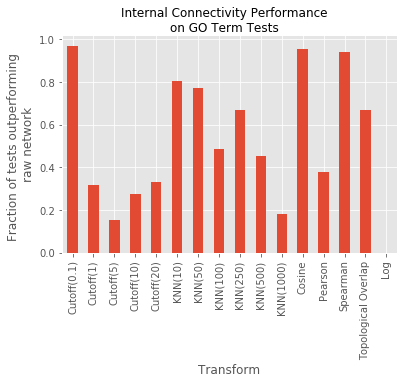

In [267]:
pd.pivot_table(wins, columns='transform', values='percent')[order].plot.bar()
plt.ylabel("Fraction of tests outperforming \nraw network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\non GO Term Tests")
plt.show()

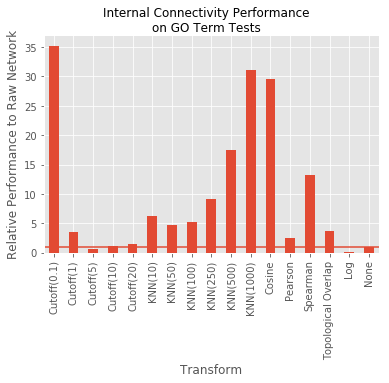

In [268]:
wins = count_ratio_outperformed(f, 'number_experimental_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
pd.pivot_table(wins, columns='transform', values='percent_enrich')[order].plot.bar()
plt.ylabel("Relative Performance to Raw Network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\non GO Term Tests")
plt.axhline(1.0)
plt.show()

Now Run the same thing for the random tests

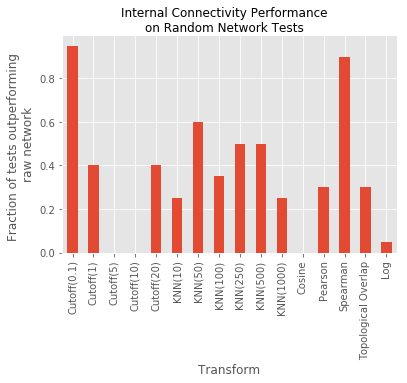

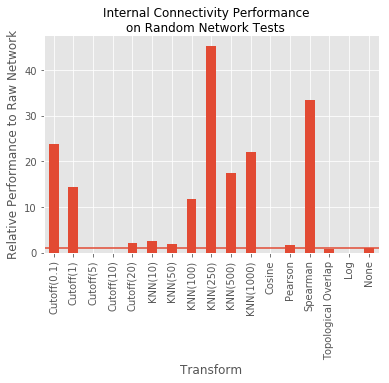

In [246]:
x = read_csv('../preprocessing_tests/connectivity_random.tsv')

f = get_fraction_significant(x)

f['test_size'] = [int(t.split(' ')[0]) for t in f['test_case']]

wins = count_times_outperformed(f, 'number_experimental_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log']
        
pd.pivot_table(wins, columns='transform', values='percent')[order].plot.bar()
plt.ylabel("Fraction of tests outperforming \nraw network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\non Random Network Tests")
plt.show()

wins = count_ratio_outperformed(f, 'number_experimental_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
pd.pivot_table(wins, columns='transform', values='percent_enrich')[order].plot.bar()
plt.ylabel("Relative Performance to Raw Network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\non Random Network Tests")
plt.axhline(1.0)
plt.show()

Get the performance of KNN over different percents of the network

In [256]:
x = read_csv('../preprocessing_tests/connectivity_gobp.tsv')
x = x.append(read_csv('../preprocessing_tests/connectivity_gocc.tsv'))

f = get_fraction_significant(x)

f['test_size'] = [int(t.split(' ')[2]) for t in f['test_case']]
f['test_type'] = [t.split(' ')[1] for t in f['test_case']]
f['test_terms'] = [t.split(' ')[3] for t in f['test_case']]

In [257]:
# Get only the rows reporting KNN performance
z = pd.DataFrame(f[[bool(re.search('KNN', t)) for t in f.transform]])
z['k'] = [int(re.search('KNN\((.*)\)', t).group(1)) for t in z.transform]

In [258]:
# Get the number of genes in each test case
test_csv = read_csv('../preprocessing_tests/modularity_cutoff_gobp.tsv').append(read_csv('../preprocessing_tests/modularity_cutoff_gocc.tsv'))
genes_per_test = test_csv.groupby(['test_case', 'test_number', 'n_genes']).size().reset_index()[['test_case', 'test_number', 'n_genes']]
z = pd.merge(z, genes_per_test, on=['test_case', 'test_number'])

In [259]:
z['k_frac'] = z.k/z.n_genes
z.plot.scatter(x='k_frac', y='fraction_experimental_significant')
plt.ylim(0.00, 0.04)

(0.0, 0.04)

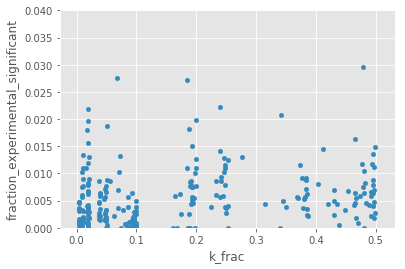

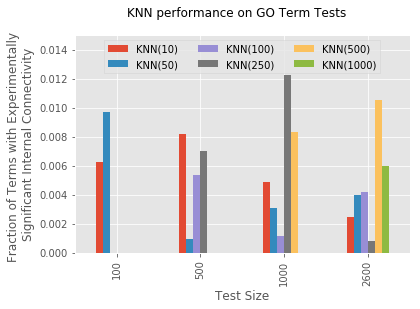

In [260]:
w = z.groupby(['transform', 'test_size'], as_index=False).agg(np.mean)
knn_order = ["KNN(%d)" % s for s in 10,50,100,250,500,1000]
w = pd.pivot_table(w, columns='transform', index='test_size', values='fraction_experimental_significant')[knn_order]
w.plot.bar()
plt.xlabel("Test Size")
plt.ylabel("Fraction of Terms with Experimentally \nSignificant Internal Connectivity")
#plt.legend(loc='best')
plt.legend(loc='upper center',
          ncol=3, fancybox=False, shadow=False)
plt.ylim(0.0,0.015)
plt.suptitle("KNN performance on GO Term Tests")

plt.show()


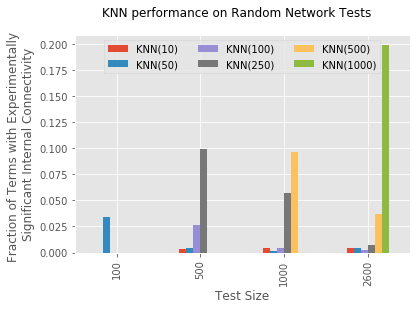

In [255]:
x = read_csv('../preprocessing_tests/connectivity_random.tsv')
f = get_fraction_significant(x)

f['test_size'] = [int(t.split(' ')[0]) for t in f['test_case']]
# Get only the rows reporting KNN performance
z = pd.DataFrame(f[[bool(re.search('KNN', t)) for t in f.transform]])
z['k'] = [int(re.search('KNN\((.*)\)', t).group(1)) for t in z.transform]
w = z.groupby(['transform', 'test_size'], as_index=False).agg(np.mean)
knn_order = ["KNN(%d)" % s for s in 10,50,100,250,500,1000]
w = pd.pivot_table(w, columns='transform', index='test_size', values='fraction_experimental_significant')[knn_order]
w.plot.bar()
plt.xlabel("Test Size")
plt.ylabel("Fraction of Terms with Experimentally \nSignificant Internal Connectivity")
#plt.legend(loc='best')
plt.legend(loc='upper center',
          ncol=3, fancybox=False, shadow=False)
plt.suptitle("KNN performance on Random Network Tests")
plt.show()


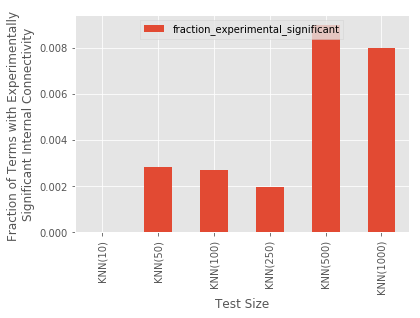

In [254]:
x = read_csv('../preprocessing_tests/connectivity_all.tsv')
f = get_fraction_significant(x)

# Get only the rows reporting KNN performance
z = pd.DataFrame(f[[bool(re.search('KNN', t)) for t in f.transform]])
z['k'] = [int(re.search('KNN\((.*)\)', t).group(1)) for t in z.transform]
w = z.groupby(['transform'], as_index=False).agg(np.mean)
knn_order = ["KNN(%d)" % s for s in 10,50,100,250,500,1000]
w = pd.pivot_table(w, columns='transform', values='fraction_experimental_significant')[knn_order]
w.plot.bar()
plt.xlabel("Test Size")
plt.ylabel("Fraction of Terms with Experimentally \nSignificant Internal Connectivity")
#plt.legend(loc='best')
plt.legend(loc='upper center',
          ncol=3, fancybox=False, shadow=False)

plt.show()


Remake of the above figures for calculated significance

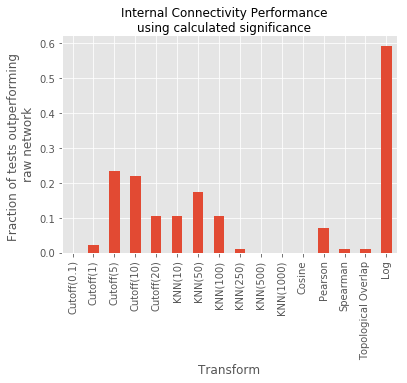

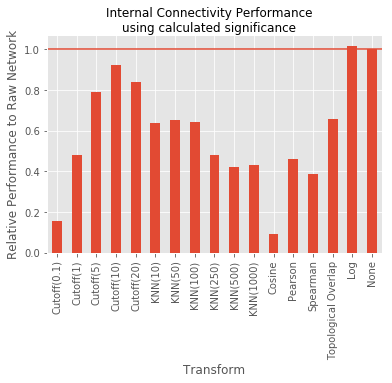

In [262]:
x = read_csv('../preprocessing_tests/connectivity_random.tsv')
x = x.append(read_csv('../preprocessing_tests/connectivity_gobp.tsv'))
x = x.append(read_csv('../preprocessing_tests/connectivity_gocc.tsv'))
f = get_fraction_significant(x)

#f['test_size'] = [int(t.split(' ')[0]) for t in f['test_case']]

wins = count_times_outperformed(f, 'number_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log']
        
pd.pivot_table(wins, columns='transform', values='percent')[order].plot.bar()
plt.ylabel("Fraction of tests outperforming \nraw network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\nusing calculated significance")
plt.show()

wins = count_ratio_outperformed(f, 'number_significant')
order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
        ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
        ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
pd.pivot_table(wins, columns='transform', values='percent_enrich')[order].plot.bar()
plt.ylabel("Relative Performance to Raw Network")
plt.xlabel("Transform")
plt.suptitle("Internal Connectivity Performance\nusing calculated significance")
plt.axhline(1.0)
plt.show()

In [37]:
f[f.transform == 'KNN(50)'].groupby(['test_size']).agg(np.mean)

test_number  total_number  number_significant  \
test_size                                                  
100                2.0   1362.888889          109.833333   
500                2.0   3012.722222          594.166667   
1000               2.0   4038.944444         1068.166667   
2600               2.0   5570.333333         1919.333333   

           number_experimental_significant  fraction_significant  \
test_size                                                          
100                              11.055556              0.092427   
500                               2.500000              0.197038   
1000                             11.944444              0.268338   
2600                             21.583333              0.344124   

           fraction_experimental_significant  
test_size                                     
100                                 0.009713  
500                                 0.000957  
1000                                0.003096  
2600                                0.003965

In [285]:
x = read_csv('../preprocessing_tests/connectivity_random.tsv')
x = x.append(read_csv('../preprocessing_tests/connectivity_gobp.tsv'))
x = x.append(read_csv('../preprocessing_tests/connectivity_gocc.tsv'))
f = get_fraction_significant(x)
f['is_random'] = ['Random' if re.search('Random', t) else 'Gene Ontology' for t in f.test_case]


20
66


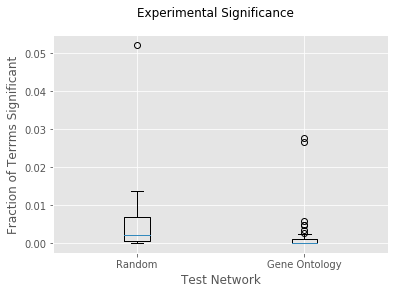

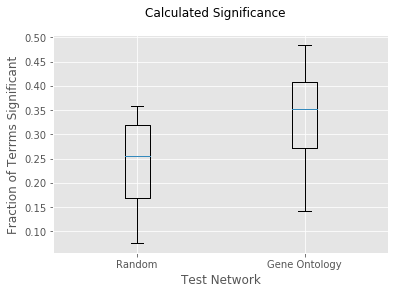

In [291]:
w = f[f.transform == 'None']
print len(w[w.is_random == 'Random'])
print len(w[w.is_random == 'Gene Ontology'])
plt.boxplot([w[w.is_random == 'Random']['fraction_experimental_significant'],
             w[w.is_random == 'Gene Ontology']['fraction_experimental_significant']],
           labels =['Random', 'Gene Ontology'])
plt.ylabel('Fraction of Terrms Significant')
plt.xlabel('Test Network')
plt.suptitle('Experimental Significance')
plt.show()
plt.boxplot([w[w.is_random == 'Random']['fraction_significant'],
             w[w.is_random == 'Gene Ontology']['fraction_significant']],
           labels =['Random', 'Gene Ontology'])
plt.ylabel('Fraction of Terrms Significant')
plt.xlabel('Test Network')
plt.suptitle('Calculated Significance')
plt.show()

# Measuring standard deviation of different transforms

In [4]:
def measure_standard_deviation(dab):
    weights = get_linear_weights(dab)
    return weights.std()

no_transform = [GraphTransform()]
bulk_transforms = [Pearson(), Spearman(), Cosine()]
neighbor_transforms = [KNN(k) for k in 10, 50, 100, 250, 500, 1000] + [TopoOverlap()]
entry_transforms = [Cutoff(p) for p in 0.1, 1, 5, 10, 20] + [Log()]

test_dab, _ = SavedListGenerator(d).load('../preprocessing_tests/genelists/random2600.genelist').generateTest()

for t in no_transform + bulk_transforms + neighbor_transforms + entry_transforms:
    transformed_dab = t.transform(test_dab)
    print t.name, "Std:", measure_standard_deviation(transformed_dab)

None Std: 0.00957019408538


../lib/clustering/transform/pearson.py:33: RuntimeWarning: invalid value encountered in sqrt
  dev = (rowsum(A**2) - (B**2) / (n-2))**.5


Pearson Std: 0.124774236809
Spearman Std: 0.133040085607
Cosine Std: 0.124827086278
KNN(10) Std: 0.0418282701916
KNN(50) Std: 0.064828047386
KNN(100) Std: 0.0835157992851
KNN(250) Std: 0.121715372092
KNN(500) Std: 0.21435245663
KNN(1000) Std: 0.131709635202
Topological Overlap Std: 0.00321453381207
Cutoff(0.1) Std: 0.00825582443299
Cutoff(1) Std: 0.00928169062386
Cutoff(5) Std: 0.00966220990236
Cutoff(10) Std: 0.00985945706802
Cutoff(20) Std: 0.0101837103917
Log Std: 0.0141623983862


In [7]:
def measure_deviation_from_mean(dab, percentiles):
    weights = get_linear_weights(dab)
    mean = weights.mean()
    percentiles = np.percentile(weights, percentiles)
    return mean, (percentiles - mean)/mean


for t in no_transform + bulk_transforms + neighbor_transforms + entry_transforms:
    transformed_dab = t.transform(test_dab)
    print t.name, "mean + deviations a percent of mean:", measure_deviation_from_mean(transformed_dab, [90,95,99])

None mean + deviations a percent of mean: (0.0072128432550548132, array([ 0.39830323,  0.47951135,  2.29785817]))
Pearson mean + deviations a percent of mean: (0.58972183209077977, array([ 0.32570843,  0.42106812,  0.54697954]))
Spearman mean + deviations a percent of mean: (0.67226361289122927, array([ 0.27561169,  0.32373224,  0.38569246]))
Cosine mean + deviations a percent of mean: (0.83438986719510433, array([ 0.16874318,  0.18547284,  0.19817908]))
KNN(10) mean + deviations a percent of mean: (0.011523130198005155, array([ -1.        ,   7.67819753,  16.35639506]))
KNN(50) mean + deviations a percent of mean: (0.037063113031639359, array([ 1.6981004 ,  3.31696064,  7.63392127]))
KNN(100) mean + deviations a percent of mean: (0.060186997957794364, array([ 1.49223263,  2.65527452,  6.1444002 ]))
KNN(250) mean + deviations a percent of mean: (0.13593001331873208, array([ 1.29529883,  1.85441008,  3.00205949]))
KNN(500) mean + deviations a percent of mean: (0.38783741675792488, array

# Semantic Similarity

In [5]:
x = read_csv('../preprocessing_tests/semantic_gobp.tsv')
x = x.append(read_csv('../preprocessing_tests/semantic_gocc.tsv'))


In [42]:
print x.columns
print x.similarity_measure.unique()
print x.transform.unique()
print x.cutoff_percentile.unique()

Index([u'test_case', u'test_number', u'transform', u'term_type',
       u'similarity_measure', u'cutoff_percentile', u'cutoff_value',
       u'pearson', u'spearman', u'total_edges', u'network_edges',
       u'similarity_edges', u'overlapping_edges', u'fold_enrichment'],
      dtype='object')
['Jaccard Index' 'Overlap Coefficient' 'Semantic Density']
['None' 'Pearson' 'Spearman' 'Cosine' 'KNN(10)' 'KNN(50)'
 'Topological Overlap' 'Cutoff(0.1)' 'Cutoff(1)' 'Cutoff(5)' 'Cutoff(10)'
 'Cutoff(20)' 'Log' 'KNN(100)' 'KNN(250)' 'KNN(500)' 'KNN(1000)']
[  0.  50.  80.  90.  95.  99.]


In [135]:
def make_plots_semantic(frame, measure, cutoff, metric):
    f = pd.DataFrame(x[(x.similarity_measure == measure)  &
                       (x.cutoff_percentile == cutoff) &
                       (x.term_type == 'BP')]).reset_index()

    f['test_size'] = [int(t.split(' ')[2]) for t in f['test_case']]
    metric_names = {
        'spearman': 'Spearman Correlation',
        'pearson': 'Pearson Correlation',
        'fold_enrichment': 'Fold Enrichment'
    }
    wins = count_times_outperformed(f, metric)
    #order = ['Cutoff(%r)' % s for s in 0.1, 1, 5, 10, 20] + \
    order = ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
            ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']

    pd.pivot_table(wins, columns='transform', values='percent')[order].plot.bar()
    plt.ylabel("Fraction of tests outperforming \nraw network")
    plt.xlabel("Transform")
    plt.suptitle("%s for %s at %d%% cutoff" % (metric_names[metric], measure, cutoff))
    plt.show()

    wins = count_ratio_outperformed(f, metric)
    pd.pivot_table(wins, columns='transform', values='percent_enrich')[order].plot.bar()
    plt.ylabel("Relative Performance to Raw Network")
    plt.xlabel("Transform")
    plt.suptitle("%s for %s at %d%% cutoff" % (metric_names[metric], measure, cutoff))
    plt.axhline(1.0)
    plt.show()
    

    g = f.groupby(['transform']).agg({metric:[np.mean, np.std]})
    g.columns = g.columns.droplevel(0)
    g = g.transpose()[order].transpose()
    g.plot.bar(y='mean', yerr='std')
    plt.suptitle("%s for %s at %d%% cutoff" % (metric_names[metric], measure, cutoff))
    plt.ylabel(metric_names[metric])
    plt.xlabel("Transform")
    plt.legend().remove()
    plt.show()



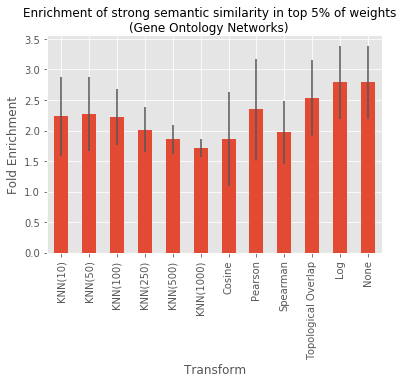

In [6]:
f = pd.DataFrame(x[(x.similarity_measure == 'Semantic Density')  &
                       (x.cutoff_percentile == 95) &
                       (x.term_type == 'BP')]).reset_index()
g = f.groupby(['transform']).agg({'fold_enrichment':[np.mean, np.std]})
g.columns = g.columns.droplevel(0)
order = ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
            ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
g = g.transpose()[order].transpose()

g.plot.bar(y='mean', yerr='std')
plt.legend().remove()
plt.suptitle("Enrichment of strong semantic similarity in top 5% of weights\n(Gene Ontology Networks)")
plt.ylabel("Fold Enrichment")
plt.xlabel("Transform")
plt.show()

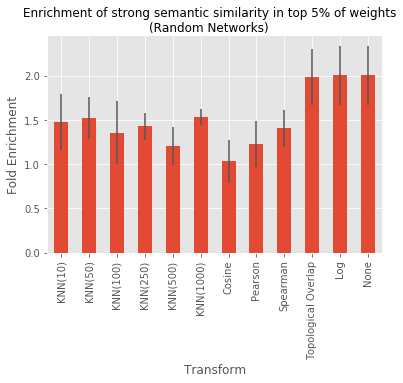

In [152]:
x = read_csv('../preprocessing_tests/semantic_random.tsv')

f = pd.DataFrame(x[(x.similarity_measure == 'Semantic Density')  &
                       (x.cutoff_percentile == 95) &
                       (x.term_type == 'BP')]).reset_index()
g = f.groupby(['transform']).agg({'fold_enrichment':[np.mean, np.std]})
g.columns = g.columns.droplevel(0)
order = ['KNN(%d)' % s for s in 10,50,100,250,500,1000] + \
            ['Cosine', 'Pearson', 'Spearman', 'Topological Overlap', 'Log', 'None']
g = g.transpose()[order].transpose()

g.plot.bar(y='mean', yerr='std')
plt.legend().remove()
plt.suptitle("Enrichment of strong semantic similarity in top 5% of weights\n(Random Networks)")
plt.ylabel("Fold Enrichment")
plt.xlabel("Transform")
plt.show()